In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [3]:
car_df = pd.read_csv(r"C:\Users\o\Desktop\ml\zero-to-mastery-ml-master\data/car-sales-extended-missing-data.csv")
car_df.head()

,Make,Colour,Odometer (KM),Doors,Price
0,Honda,White,35431.0,4.0,15323.0
1,BMW,Blue,192714.0,5.0,19943.0
2,Honda,White,84714.0,4.0,28343.0
3,Toyota,White,154365.0,4.0,13434.0
4,Nissan,Blue,181577.0,3.0,14043.0


In [4]:
car_df.isna().sum()

Make             49
Colour           50
Odometer (KM)    50
Doors            50
Price            50
dtype: int64

In [30]:
car_df.dropna(subset=['Price'], inplace=True)

In [31]:
car_df.isna().sum()

Make             47
Colour           46
Odometer (KM)    48
Doors            47
Price             0
dtype: int64

In [51]:
categorical_features = ['Make', 'Colour']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_features = ['Odometer (KM)']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

door_features = ['Doors']
door_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=4)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer,  categorical_features),
    ('num', numeric_transformer, numeric_features),
    ('door', door_transformer, door_features)
])

models = {
    'dummy': DummyRegressor(),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42)
    
}

x = car_df.drop('Price', axis=1)
y = car_df['Price']

scoring = {
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "R2": "r2"}

for model_name, model in models.items():
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)])
    scores = cross_validate(model_pipeline, x, y, cv=5, scoring=scoring)
    print(f"Model: {model_name}", )
    for metric in scoring.keys():
        mean_score = np.mean(scores[f'test_{metric}'])
        if "neg" in scoring[metric]:
            mean_score = -mean_score 
        print(f"  {metric}: {mean_score:.2f}")
    #print(f'fitting...{model_name}')
    

Model: dummy
  MAE: 6813.27
  MSE: 73763925.75
  R2: -0.01
Model: LinearRegression
  MAE: 5821.58
  MSE: 51238255.59
  R2: 0.30
Model: RandomForestRegressor
  MAE: 5970.11
  MSE: 56345100.93
  R2: 0.23
Model: GradientBoostingRegressor
  MAE: 5574.92
  MSE: 47966744.57
  R2: 0.34


In [82]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

categorical_features = ['Make', 'Colour']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_features = ['Odometer (KM)']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

door_features = ['Doors']
door_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=4)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features),
    ('door', door_transformer, door_features)
])

models = {
    "Dummy": DummyRegressor(),
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

param_grids = {
    "Dummy": {}, 
    "LinearRegression": {}, 
    "RandomForest": {
        "model__n_estimators": [100, 200, 500],
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    "GradientBoosting": {
        "model__n_estimators": [100, 200, 500],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    }
}


x = car_df.drop('Price', axis=1)
y = car_df['Price']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

results_list= []

for name, model in models.items():
    print(f" Model: {name}")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    if param_grids[name]: 
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grids[name],
            n_iter=10,
            scoring='r2',
            n_jobs=-1,
            cv=5,
            verbose=1,
            random_state=42
        )
        search.fit(xtrain, ytrain)
        best_model = search.best_estimator_
        print("Best Params:", search.best_params_)
        print("Best CV R2:", search.best_score_)
    else:  
        pipeline.fit(xtrain, ytrain)
        best_model = pipeline
    
    y_pred = best_model.predict(xtest)

    
    results_list.append({
    "Model": name,
    "MAE": mean_absolute_error(ytest, y_pred),
    "MSE": mean_squared_error(ytest, y_pred),
    "R2": r2_score(ytest, y_pred)})

df_results = pd.DataFrame(results_list)
print(df_results)

 Model: Dummy
 Model: LinearRegression
 Model: RandomForest
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 5}
Best CV R2: 0.3205747122859147
 Model: GradientBoosting
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 3, 'model__learning_rate': 0.01}
Best CV R2: 0.28090620677840533
              Model          MAE           MSE        R2
0             Dummy  6738.203781  6.818849e+07 -0.018351
1  LinearRegression  5742.721160  4.973786e+07  0.257197
2      RandomForest  5401.512721  4.508958e+07  0.326616
3  GradientBoosting  5639.940653  4.714684e+07  0.295892


In [86]:
import matplotlib.pyplot as plt

In [87]:
df_results

,Model,MAE,MSE,R2
0,Dummy,6738.203781,6.818849e+07,-0.018351
1,LinearRegression,5742.721160,4.973786e+07,0.257197
2,RandomForest,5401.512721,4.508958e+07,0.326616
3,GradientBoosting,5639.940653,4.714684e+07,0.295892


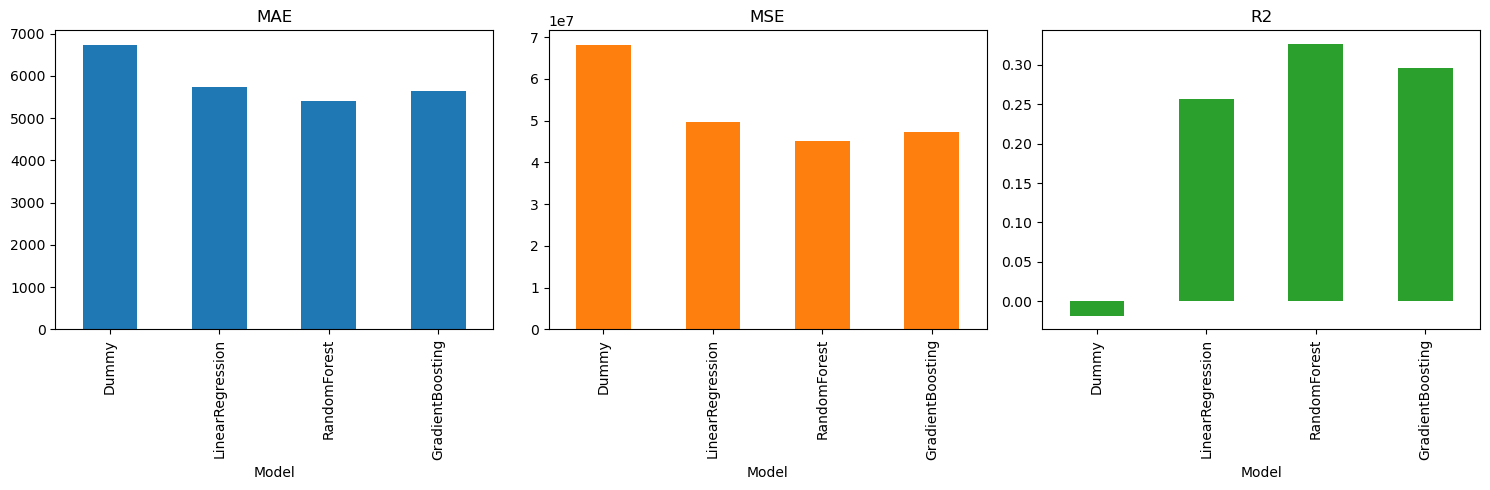

In [92]:
axes = df_results.plot(
    x="Model",
    y=["MAE", "MSE", "R2"],
    kind="bar",
    subplots=True,
    layout=(1,3),
    figsize=(15,5),
    legend=False
)

plt.tight_layout()

plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")

plt.show()

In [94]:
with open("script.py", "w") as f:
    f.write("""from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

categorical_features = ['Make', 'Colour']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_features = ['Odometer (KM)']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

door_features = ['Doors']
door_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=4)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features),
    ('door', door_transformer, door_features)
])

models = {
    "Dummy": DummyRegressor(),
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

param_grids = {
    "Dummy": {}, 
    "LinearRegression": {}, 
    "RandomForest": {
        "model__n_estimators": [100, 200, 500],
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    "GradientBoosting": {
        "model__n_estimators": [100, 200, 500],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    }
}


x = car_df.drop('Price', axis=1)
y = car_df['Price']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

results_list= []

for name, model in models.items():
    print(f" Model: {name}")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    if param_grids[name]: 
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grids[name],
            n_iter=10,
            scoring='r2',
            n_jobs=-1,
            cv=5,
            verbose=1,
            random_state=42
        )
        search.fit(xtrain, ytrain)
        best_model = search.best_estimator_
        print("Best Params:", search.best_params_)
        print("Best CV R2:", search.best_score_)
    else:  
        pipeline.fit(xtrain, ytrain)
        best_model = pipeline
    
    y_pred = best_model.predict(xtest)

    
    results_list.append({
    "Model": name,
    "MAE": mean_absolute_error(ytest, y_pred),
    "MSE": mean_squared_error(ytest, y_pred),
    "R2": r2_score(ytest, y_pred)})

df_results = pd.DataFrame(results_list)
print(df_results)""")